In [1]:
from ica_benchmark.io.load import Physionet_2009_Dataset, BCI_IV_Comp_Dataset, OpenBMI_Dataset
import mne
from pathlib import Path
from collections import namedtuple

mne.set_log_level(False)

physionet_dataset_folderpath = Path('/home/paulo/Documents/datasets/Physionet')
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
openbmi_dataset_folderpath = Path('/home/paulo/Documents/datasets/OpenBMI/edf/')

physionet_dataset = Physionet_2009_Dataset(physionet_dataset_folderpath)
bci_dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)
openbmi_dataset = OpenBMI_Dataset(openbmi_dataset_folderpath)

In [2]:
bci_kwargs = dict(
    train=dict(
        reject=False,
        tmin=0,
        tmax=4,
        session=1
    ),
    test=dict(
        reject=False,
        tmin=0,
        tmax=4,
        session=2
    )
)
physionet_kwargs = dict(
    train=dict(
        reject=False,
        tmin=0,
        tmax=2,
        tasks=["2"]
    ),
    test=dict(
        reject=False,
        tmin=0,
        tmax=2,
        tasks=["2"]
    )
)
openbmi_kwargs = dict(
    train=dict(
        reject=False,
        tmin=1,
        tmax=3.5,
        session=1,
    ),
    test=dict(
        reject=False,
        tmin=1,
        tmax=3.5,
        session=2,
    )
)



In [3]:
from sklearn.base import BaseEstimator
from mne.time_frequency import psd_array_welch, psd_welch
import numpy as np
import mne

class ConcatenateChannelsPSD(BaseEstimator):
    def __init__(self):
        super(ConcatenateChannelsPSD).__init__()

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        n = len(x)
        return x.reshape(n, -1)


class GetEpochsData(BaseEstimator):
    def __init__(self):
        super(GetEpochsData).__init__()

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x.get_data()


class PSD(BaseEstimator):
    BANDS_DICT = {
#         "delta": (1, 4),
#         "theta": (4, 8),
#         "mu": (8, 13),
        "mu": (8, 13),
#         "beta": (13, 25),
        "beta": (13, 25),
#         "gamma": (25, 40)
    }
    def __init__(self, **kwargs):
        super(PSD).__init__()
        self.kwargs = kwargs
        
    def set_params(**params):
        for param in params:
            assert params in ["picks", "n_fft", "n_overlap", "n_per_seg"]
        self.kwargs.update(params)
    
    def get_params(self, *args, **kwargs):
        return self.kwargs
        
    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        if isinstance(x, list):
            x = mne.concatenate_epochs(x)
            psds, freqs = psd_welch(x, ** self.kwargs)
        if isinstance(x, mne.Epochs):
#             psds, freqs = psd_welch(x, ** self.kwargs)
            x = x.get_data()
        if isinstance(x, np.ndarray):
            psds, freqs = psd_array_welch(x, ** self.kwargs)
        if ("average" in self.kwargs) and (self.kwargs["average"] is None):
            psds = psds.sum(axis=3)
        self.freqs = freqs

        band_spectras = list()
        for band, (lfreq, hfreq) in self.BANDS_DICT.items():
            band_spectra = psds[:, :, (freqs >= lfreq) & (freqs < hfreq)]
            band_spectras.append(
                band_spectra.sum(axis=2, keepdims=True)
            )
        
        band_spectras = np.concatenate(band_spectras, axis=2)
            
        return band_spectras

In [4]:
from itertools import permutations

def split_epochs(e, seed=1):
    np.random.seed(seed)
    e.load_data()
    labels = e.events[:, 2]
    labels_indexes = list()
    
    assert len(set(np.unique(labels))) == 2, set(np.unique(labels))
    
    for l in np.unique(labels):
        idx = np.where(labels == l)[0]
        np.random.shuffle(idx)
        labels_indexes.append(
            idx.tolist()
        )
    
    idx_train, idx_test = list(), list()
    for class_index_list in labels_indexes:
        N = len(class_index_list) // 2
        idx_train += class_index_list[:N]
        idx_test += class_index_list[N:]
    

    mask_train = np.isin(range(len(e)), idx_train)
    mask_test = np.isin(range(len(e)), idx_test)

    train_epochs = e[mask_train]
    test_epochs = e[mask_test]
    
    return train_epochs, test_epochs



In [5]:
from mne.decoding import CSP
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import balanced_accuracy_score
from ica_benchmark.io.load import OpenBMI_Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import warnings

warnings.filterwarnings("ignore")


filter_kwargs = dict(
    method="iir",
    iir_params=dict(
        order=5,
        ftype="butter"
    )
)

results = list()

datasets = [
    bci_dataset,
    openbmi_dataset,
    physionet_dataset,
]

for dataset in datasets:
    dataset_name = dataset.__class__.__name__
    print("Dataset:", dataset_name)
    for uid in sorted(dataset.list_uids(), key=int):
        kwargs = {
            bci_dataset: bci_kwargs,
            openbmi_dataset: openbmi_kwargs,
            physionet_dataset: physionet_kwargs,
        }[dataset]
        train_epochs = dataset.load_subject(uid, **kwargs["train"])[0]
        test_epochs = dataset.load_subject(uid, **kwargs["test"])[0]

        train_epochs.load_data()
        test_epochs.load_data()
        
        if dataset is bci_dataset:
            train_epochs = train_epochs[[np.isin(i, (0, 1)) for i in train_epochs.events[:, 2]]]
            test_epochs = test_epochs[[np.isin(i, (0, 1)) for i in test_epochs.events[:, 2]]]
            
        elif dataset is physionet_dataset:
            train_epochs = train_epochs[["3", "4"]]
            test_epochs = test_epochs[["3", "4"]]
            train_epochs, test_epochs = split_epochs(train_epochs)

        elif dataset is openbmi_dataset:
            pass


        train_epochs = train_epochs.filter(8, 30, **filter_kwargs)
        test_epochs = test_epochs.filter(8, 30, **filter_kwargs)

        x_train = train_epochs.get_data()
        x_test = test_epochs.get_data()
        y_train = train_epochs.events[:, 2]
        y_test = test_epochs.events[:, 2]

        csp = CSP(n_components=5, log=True)
        csp.fit(x_train, y_train)

        x_train = csp.transform(x_train)
        x_test = csp.transform(x_test)

        lr = LinearDiscriminantAnalysis().fit(x_train, y_train)

        train_pred = lr.predict(x_train)
        test_pred = lr.predict(x_test)

        train_acc = balanced_accuracy_score(y_train, train_pred)
        test_acc = balanced_accuracy_score(y_test, test_pred)

        print("\t[{}] {:.2f}/{:.2f}".format(uid, train_acc, test_acc))

        results.append([dataset_name, uid, train_acc, test_acc])
        
        del train_epochs, test_epochs

Dataset: BCI_IV_Comp_Dataset
	[1] 0.89/0.83
	[2] 0.74/0.58
	[3] 0.98/0.92
	[4] 0.86/0.62
	[5] 0.65/0.52
	[6] 0.86/0.59
	[7] 0.89/0.69
	[8] 0.97/0.94
	[9] 0.85/0.92
Dataset: OpenBMI_Dataset
	[1] 0.67/0.53
	[2] 0.99/0.60
	[3] 0.97/0.88
	[4] 0.54/0.47
	[5] 0.98/0.74
	[6] 0.91/0.81
	[7] 0.81/0.55
	[8] 0.80/0.58
	[9] 0.95/0.55
	[10] 0.80/0.50
	[11] 0.67/0.50
	[12] 0.87/0.52
	[13] 0.86/0.60
	[14] 0.81/0.60
	[15] 0.88/0.37
	[16] 0.64/0.47
	[17] 0.70/0.50
	[18] 0.98/0.77
	[19] 0.88/0.76
	[20] 0.84/0.45
	[21] 0.99/0.98
	[22] 0.78/0.54
	[23] 0.99/0.85
	[24] 0.95/0.54
	[25] 0.69/0.51
	[26] 0.81/0.48
	[27] 0.80/0.59
	[28] 0.81/0.67
	[29] 0.83/0.71
	[30] 0.77/0.56
	[31] 0.84/0.52
	[32] 0.99/0.98
	[33] 1.00/0.93
	[34] 0.58/0.51
	[35] 0.92/0.57
	[36] 0.96/0.98
	[37] 0.96/0.85
	[38] 0.63/0.47
	[39] 0.77/0.55
	[40] 0.77/0.50
	[41] 0.78/0.61
	[42] 0.83/0.53
	[43] 0.95/0.50
	[44] 0.97/0.95
	[45] 0.94/0.88
	[46] 0.53/0.63
	[47] 0.78/0.53
	[48] 0.89/0.64
	[49] 0.95/0.68
	[50] 0.78/0.50
	[51] 0.71/0.56
	[52

In [6]:
results_df = pd.DataFrame(results, columns=["dataset", "uid", "train_acc", "test_acc"])
results_df.groupby("dataset").describe().test_acc

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
BCI_IV_Comp_Dataset,9.0,0.736883,0.167944,0.520833,0.590278,0.694444,0.916667,0.944444
OpenBMI_Dataset,54.0,0.628148,0.159611,0.370000,0.510000,0.565000,0.732500,0.980000
Physionet_2009_Dataset,109.0,0.560482,0.147402,0.303030,0.447619,0.556818,0.650000,1.000000


dataset
BCI_IV_Comp_Dataset       [[AxesSubplot(0.125,0.125;0.775x0.755)]]
OpenBMI_Dataset           [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Physionet_2009_Dataset    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

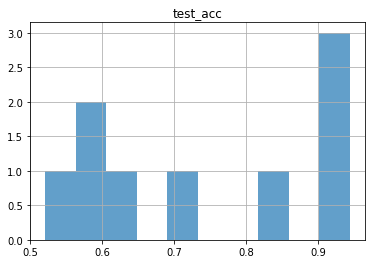

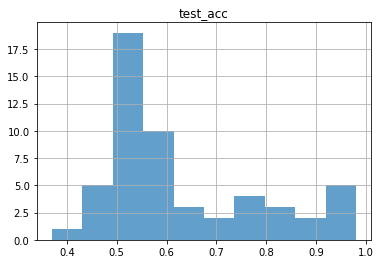

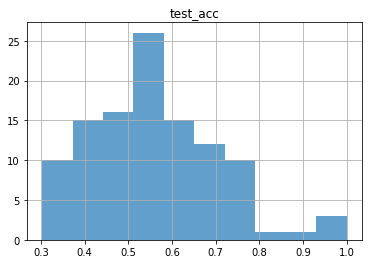

In [7]:
results_df.groupby("dataset").hist(alpha=.7, column="test_acc", bins=10)